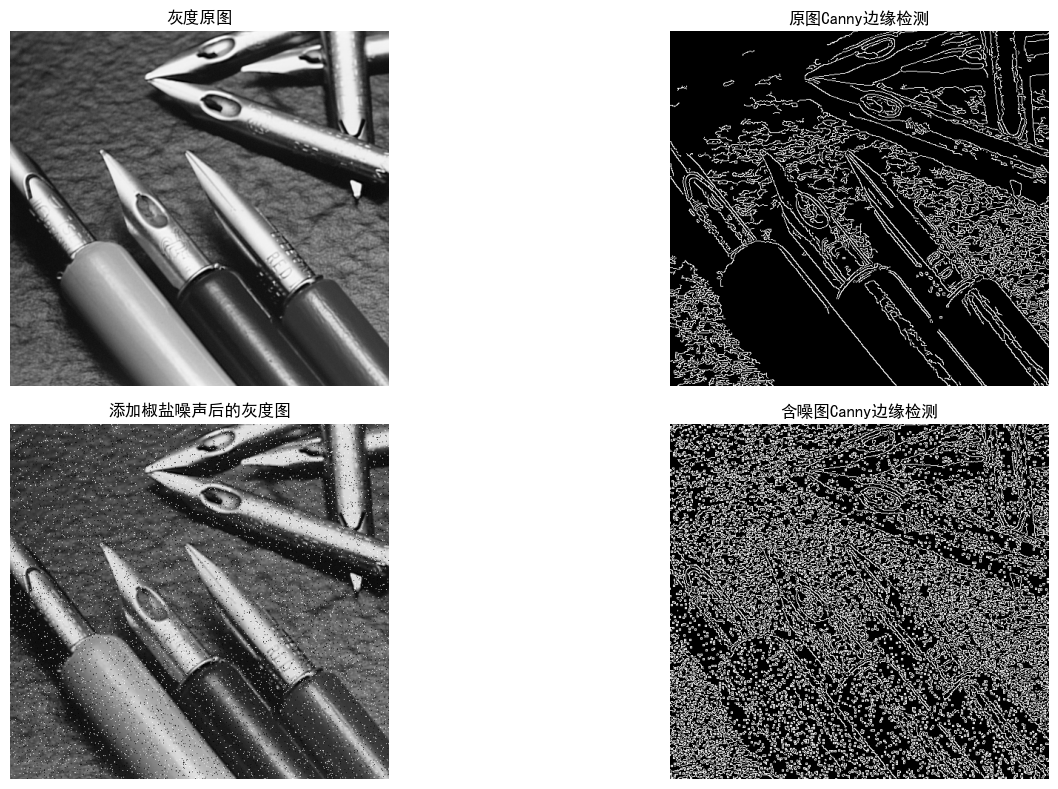

In [22]:
# 导入核心库
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 设置中文显示（解决标题乱码）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ---------------------- 1. 定义椒盐噪声生成函数 ----------------------
def add_salt_pepper_noise(img, noise_ratio=0.05):
    """添加椒盐噪声"""
    noisy_img = img.copy()
    noise_num = int(noise_ratio * img.size)
    # 盐噪声（白点，255）
    for _ in range(noise_num // 2):
        x = np.random.randint(0, img.shape[0])
        y = np.random.randint(0, img.shape[1])
        noisy_img[x, y] = 255
    # 椒噪声（黑点，0）
    for _ in range(noise_num - noise_num // 2):
        x = np.random.randint(0, img.shape[0])
        y = np.random.randint(0, img.shape[1])
        noisy_img[x, y] = 0
    return noisy_img

# ---------------------- 2. 核心流程：读取图片→加噪声→Canny检测 ----------------------
# 读取图片（替换为你的图片路径）
img = cv2.imread("test.jpg")
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 转灰度

# 添加椒盐噪声（噪声比例0.05，可调整）
noisy_gray = add_salt_pepper_noise(gray_img, noise_ratio=0.05)

# Canny边缘检测（分别检测原图和含噪图）
canny_origin = cv2.Canny(gray_img, 50, 150)    # 原图Canny
canny_noisy = cv2.Canny(noisy_gray, 50, 150)  # 含噪图Canny

# ---------------------- 3. 可视化对比（4张子图） ----------------------
plt.figure(figsize=(16, 8))

# 1. 灰度原图
plt.subplot(2, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('灰度原图', fontsize=12)
plt.axis('off')

# 2. 原图Canny结果
plt.subplot(2, 2, 2)
plt.imshow(canny_origin, cmap='gray')
plt.title('原图Canny边缘检测', fontsize=12)
plt.axis('off')

# 3. 含椒盐噪声的灰度图
plt.subplot(2, 2, 3)
plt.imshow(noisy_gray, cmap='gray')
plt.title('添加椒盐噪声后的灰度图', fontsize=12)
plt.axis('off')

# 4. 含噪图Canny结果
plt.subplot(2, 2, 4)
plt.imshow(canny_noisy, cmap='gray')
plt.title('含噪图Canny边缘检测', fontsize=12)
plt.axis('off')

plt.tight_layout()
plt.show()

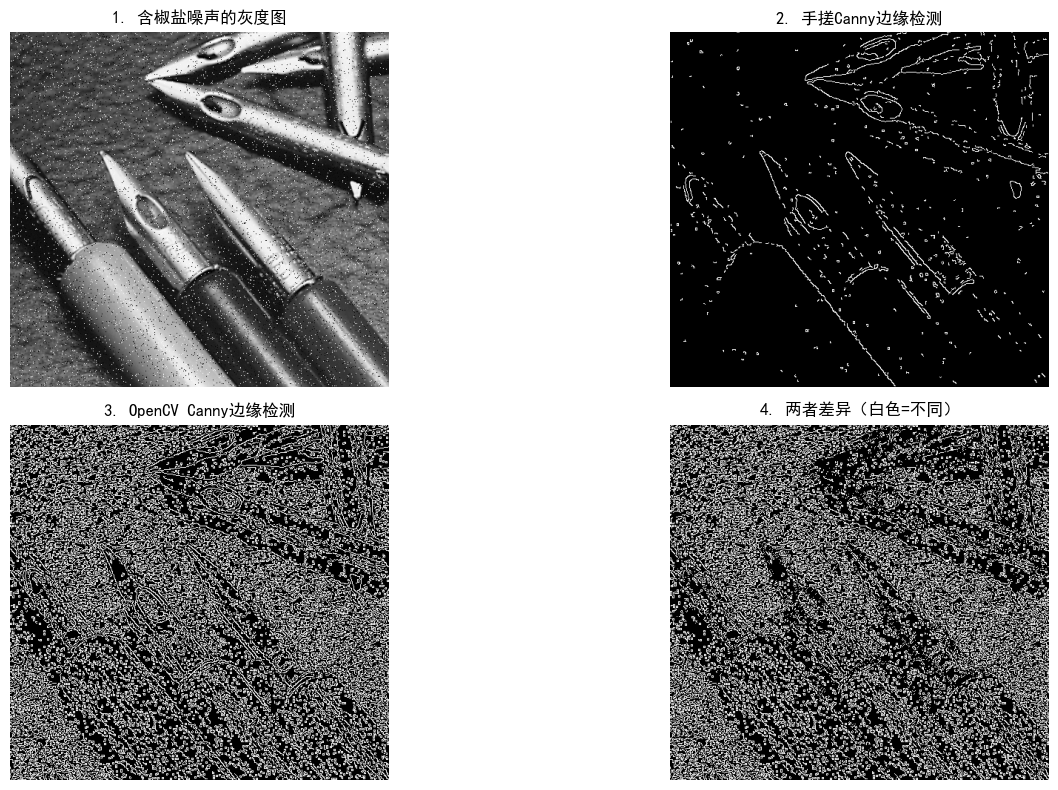

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve  # 用于卷积（比手动循环快）

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ===================== 第一步：实现核心工具函数 =====================
def gaussian_kernel(size, sigma=1.4):
    """生成高斯核（Canny默认sigma=1.4，核大小3×3）"""
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    g = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return g / g.sum()  # 归一化

def add_salt_pepper_noise(img, noise_ratio=0.05):
    """生成椒盐噪声（用于测试）"""
    noisy_img = img.copy()
    noise_num = int(noise_ratio * img.size)
    # 盐噪声（白点）
    coords = [np.random.randint(0, i-1, noise_num//2) for i in img.shape]
    noisy_img[coords[0], coords[1]] = 255
    # 椒噪声（黑点）
    coords = [np.random.randint(0, i-1, noise_num-noise_num//2) for i in img.shape]
    noisy_img[coords[0], coords[1]] = 0
    return noisy_img

# ===================== 第二步：手搓Canny核心流程 =====================
def manual_canny(img, low_threshold=50, high_threshold=150, sigma=1.4):
    """
    纯手动实现Canny边缘检测
    :param img: 灰度图（0-255）
    :param low_threshold: 低阈值
    :param high_threshold: 高阈值
    :param sigma: 高斯滤波标准差
    :return: Canny边缘检测结果（二值图）
    """
    # ---------------------- 步骤1：高斯滤波去噪 ----------------------
    kernel = gaussian_kernel(3, sigma)
    img_blur = convolve(img, kernel)  # 卷积实现高斯平滑

    # ---------------------- 步骤2：计算梯度（Sobel算子） ----------------------
    # Sobel核定义
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # 计算x/y方向梯度
    grad_x = convolve(img_blur, sobel_x)
    grad_y = convolve(img_blur, sobel_y)

    # 梯度大小（边缘强度）
    grad_mag = np.hypot(grad_x, grad_y)  # 等价于sqrt(grad_x² + grad_y²)
    grad_mag = (grad_mag / grad_mag.max()) * 255  # 归一化到0-255

    # 梯度方向（角度，0-180°）
    grad_dir = np.arctan2(grad_y, grad_x) * 180 / np.pi
    grad_dir[grad_dir < 0] += 180  # 统一到0-180°

    # ---------------------- 步骤3：非极大值抑制（边缘细化） ----------------------
    height, width = img.shape
    nms = np.zeros((height, width), dtype=np.float32)
    for i in range(1, height-1):
        for j in range(1, width-1):
            angle = grad_dir[i, j]
            mag = grad_mag[i, j]

            # 量化梯度方向为4个主方向：0°(水平)、45°、90°(垂直)、135°
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                # 水平方向：比较左右像素
                neighbors = [grad_mag[i, j-1], grad_mag[i, j+1]]
            elif 22.5 <= angle < 67.5:
                # 45°方向：比较左上/右下像素
                neighbors = [grad_mag[i-1, j-1], grad_mag[i+1, j+1]]
            elif 67.5 <= angle < 112.5:
                # 垂直方向：比较上下像素
                neighbors = [grad_mag[i-1, j], grad_mag[i+1, j]]
            else:
                # 135°方向：比较右上/左下像素
                neighbors = [grad_mag[i-1, j+1], grad_mag[i+1, j-1]]

            # 仅保留局部最大值
            if mag >= max(neighbors):
                nms[i, j] = mag
            else:
                nms[i, j] = 0

    # ---------------------- 步骤4：双阈值判决 + 弱边缘连通性 ----------------------
    # 1. 标记强/弱/非边缘
    strong_edge = (nms >= high_threshold)
    weak_edge = (nms >= low_threshold) & (nms < high_threshold)

    # 2. 弱边缘连通性分析（仅保留和强边缘连通的弱边缘）
    # 8邻域遍历找连通的强边缘
    canny = np.zeros_like(nms)
    canny[strong_edge] = 255  # 强边缘直接保留
    height, width = img.shape

    # 遍历弱边缘像素，检查邻域是否有强边缘
    for i in range(1, height-1):
        for j in range(1, width-1):
            if weak_edge[i, j]:
                # 检查8邻域
                if np.any(strong_edge[i-1:i+2, j-1:j+2]):
                    canny[i, j] = 255

    return canny

# ===================== 第三步：测试手搓Canny（对比OpenCV） =====================
# 1. 读取并预处理图片
img = plt.imread("test.jpg")  # 替换为你的图片路径
if len(img.shape) == 3:
    img_gray = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])  # 转灰度
else:
    img_gray = img
img_gray = (img_gray / img_gray.max()) * 255  # 归一化到0-255

# 2. 添加椒盐噪声（测试抗噪性）
img_noisy = add_salt_pepper_noise(img_gray, noise_ratio=0.05)

# 3. 运行手搓Canny
manual_canny_result = manual_canny(img_noisy, low_threshold=30, high_threshold=90)

# 4. 运行OpenCV Canny（对比）
import cv2
cv2_canny_result = cv2.Canny((img_noisy).astype(np.uint8), 30, 90)

# ===================== 第四步：可视化对比 =====================
plt.figure(figsize=(16, 8))

# 1. 含噪灰度图
plt.subplot(2, 2, 1)
plt.imshow(img_noisy, cmap='gray')
plt.title('1. 含椒盐噪声的灰度图', fontsize=12)
plt.axis('off')

# 2. 手搓Canny结果
plt.subplot(2, 2, 2)
plt.imshow(manual_canny_result, cmap='gray')
plt.title('2. 手搓Canny边缘检测', fontsize=12)
plt.axis('off')

# 3. OpenCV Canny结果
plt.subplot(2, 2, 3)
plt.imshow(cv2_canny_result, cmap='gray')
plt.title('3. OpenCV Canny边缘检测', fontsize=12)
plt.axis('off')

# 4. 对比差异（手搓 - OpenCV）
plt.subplot(2, 2, 4)
diff = np.abs(manual_canny_result - cv2_canny_result)
plt.imshow(diff, cmap='gray')
plt.title('4. 两者差异（白色=不同）', fontsize=12)
plt.axis('off')

plt.tight_layout()
plt.show()

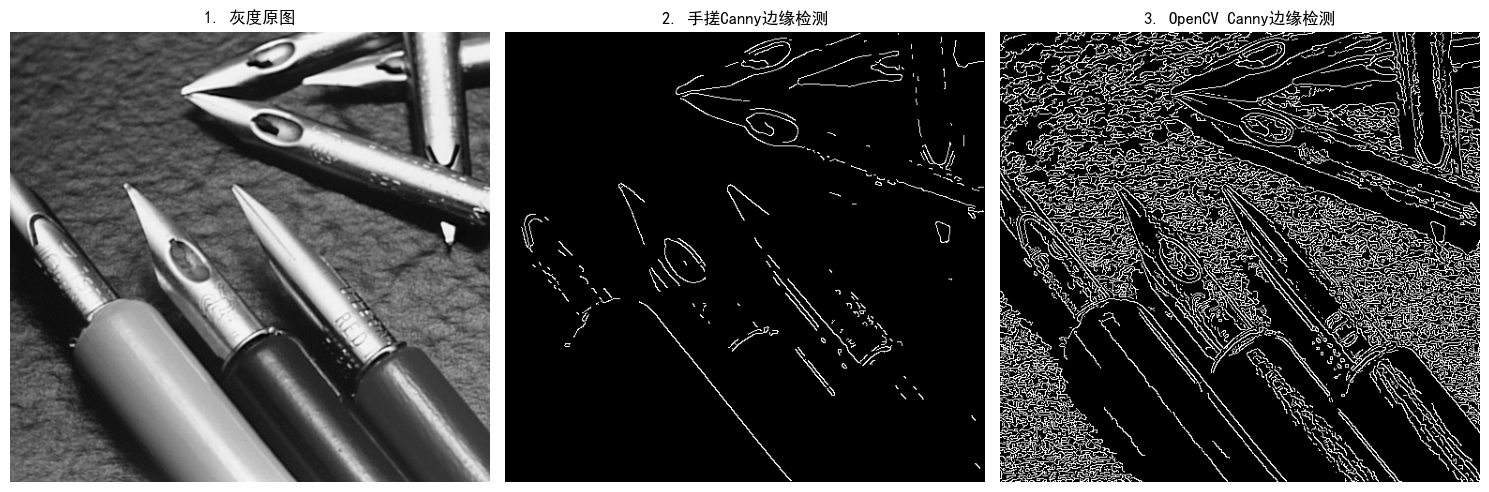

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve  # 用于卷积计算

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ===================== 核心工具函数 =====================
def gaussian_kernel(size, sigma=1.4):
    """生成高斯核（Canny去噪核心）"""
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    g = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return g / g.sum()  # 归一化

# ===================== 纯手搓Canny核心实现 =====================
def manual_canny(img, low_threshold=50, high_threshold=150, sigma=1.4):
    """
    纯手动实现Canny边缘检测（无噪声相关逻辑）
    :param img: 灰度图（0-255）
    :param low_threshold: 低阈值
    :param high_threshold: 高阈值
    :param sigma: 高斯滤波标准差
    :return: Canny边缘检测结果（二值图）
    """
    # 步骤1：高斯滤波去噪（Canny原生步骤，非额外噪声处理）
    kernel = gaussian_kernel(3, sigma)
    img_blur = convolve(img, kernel)

    # 步骤2：计算梯度（Sobel算子）
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    grad_x = convolve(img_blur, sobel_x)
    grad_y = convolve(img_blur, sobel_y)

    # 梯度大小（归一化到0-255）
    grad_mag = np.hypot(grad_x, grad_y)
    grad_mag = (grad_mag / grad_mag.max()) * 255

    # 梯度方向（统一到0-180°）
    grad_dir = np.arctan2(grad_y, grad_x) * 180 / np.pi
    grad_dir[grad_dir < 0] += 180

    # 步骤3：非极大值抑制（边缘细化）
    height, width = img.shape
    nms = np.zeros_like(grad_mag)
    for i in range(1, height-1):
        for j in range(1, width-1):
            angle = grad_dir[i, j]
            mag = grad_mag[i, j]

            # 量化梯度方向为4个主方向
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                neighbors = [grad_mag[i, j-1], grad_mag[i, j+1]]  # 水平
            elif 22.5 <= angle < 67.5:
                neighbors = [grad_mag[i-1, j-1], grad_mag[i+1, j+1]]  # 45°
            elif 67.5 <= angle < 112.5:
                neighbors = [grad_mag[i-1, j], grad_mag[i+1, j]]  # 垂直
            else:
                neighbors = [grad_mag[i-1, j+1], grad_mag[i+1, j-1]]  # 135°

            # 保留局部最大值
            nms[i, j] = mag if mag >= max(neighbors) else 0

    # 步骤4：双阈值判决 + 弱边缘连通性
    strong_edge = (nms >= high_threshold)
    weak_edge = (nms >= low_threshold) & (nms < high_threshold)

    # 仅保留和强边缘连通的弱边缘
    canny = np.zeros_like(nms)
    canny[strong_edge] = 255
    height, width = img.shape
    for i in range(1, height-1):
        for j in range(1, width-1):
            if weak_edge[i, j] and np.any(strong_edge[i-1:i+2, j-1:j+2]):
                canny[i, j] = 255

    return canny

# ===================== 测试手搓Canny（对比OpenCV） =====================
# 1. 读取并预处理图片（无噪声添加）
img = plt.imread("test.jpg")  # 替换为你的图片路径
if len(img.shape) == 3:
    img_gray = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])  # 转灰度
else:
    img_gray = img
img_gray = (img_gray / img_gray.max()) * 255  # 归一化到0-255

# 2. 运行手搓Canny
manual_result = manual_canny(img_gray, low_threshold=30, high_threshold=90)

# 3. 运行OpenCV Canny（对比验证）
import cv2
cv2_result = cv2.Canny(img_gray.astype(np.uint8), 30, 90)

# ===================== 可视化对比 =====================
plt.figure(figsize=(15, 5))

# 1. 灰度原图
plt.subplot(1, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('1. 灰度原图', fontsize=12)
plt.axis('off')

# 2. 手搓Canny结果
plt.subplot(1, 3, 2)
plt.imshow(manual_result, cmap='gray')
plt.title('2. 手搓Canny边缘检测', fontsize=12)
plt.axis('off')

# 3. OpenCV Canny结果
plt.subplot(1, 3, 3)
plt.imshow(cv2_result, cmap='gray')
plt.title('3. OpenCV Canny边缘检测', fontsize=12)
plt.axis('off')

plt.tight_layout()
plt.show()

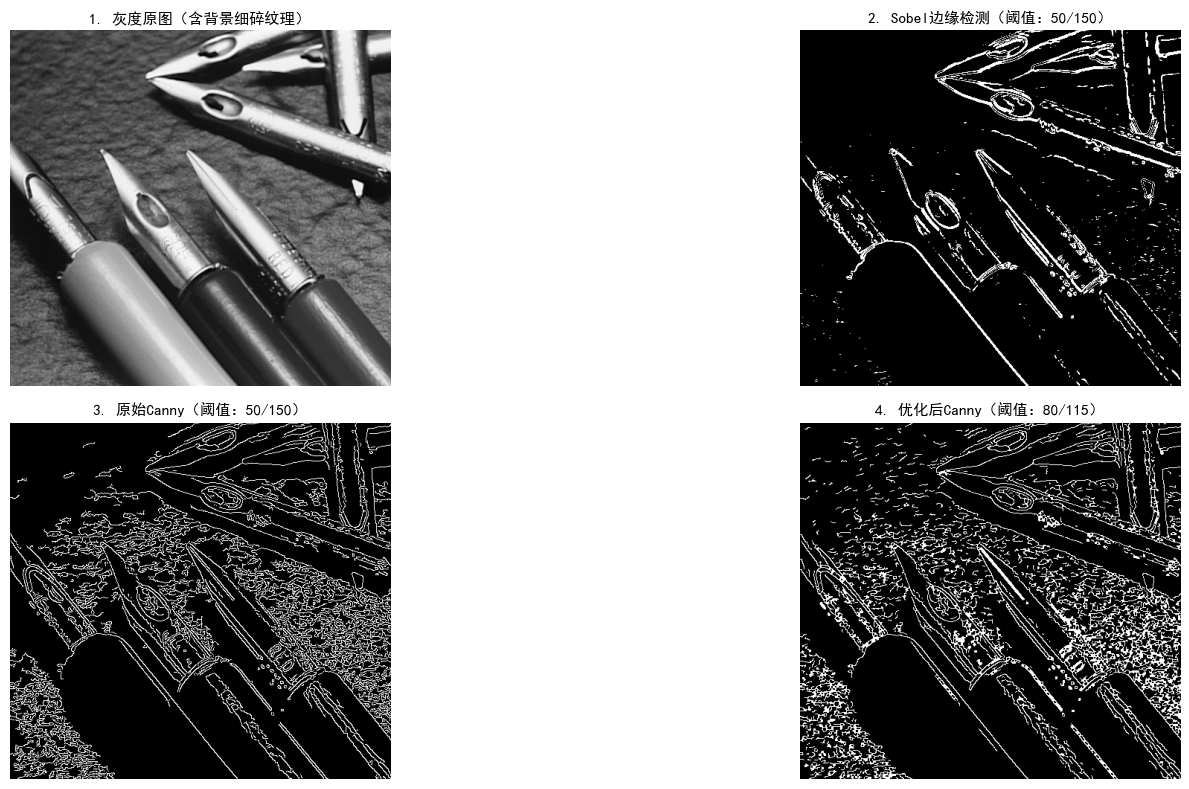

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ===================== 核心配置（仅需改图片路径） =====================
IMG_PATH = "test.jpg"  # 替换为你的图片路径（优先选有背景纹理的图：布料/墙面/树叶等）
LOW_THRESH = 50        # 统一阈值（公平对比）
HIGH_THRESH = 150      # 统一阈值（公平对比）

# 设置中文显示（避免乱码）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ===================== 1. 读取并预处理图片 =====================
img = cv2.imread(IMG_PATH)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 转灰度

# ===================== 2. 实现Sobel（和Canny对齐阈值逻辑） =====================
def sobel_with_threshold(gray, low_thresh, high_thresh):
    """Sobel边缘检测（加阈值筛选，和Canny公平对比）"""
    # 计算x/y方向梯度
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    # 梯度大小+归一化
    sobel_mag = np.hypot(sobel_x, sobel_y)
    sobel_mag = (sobel_mag / sobel_mag.max()) * 255
    # 阈值筛选（模拟Canny的阈值逻辑）
    sobel_result = np.zeros_like(sobel_mag, dtype=np.uint8)
    sobel_result[(sobel_mag >= low_thresh) & (sobel_mag <= high_thresh)] = 255
    return sobel_result

# ===================== 3. 计算Sobel/Canny/优化后Canny =====================
# 基础版（背景纹理干扰对比）
sobel_result = sobel_with_threshold(gray, LOW_THRESH, HIGH_THRESH)
canny_original = cv2.Canny(gray, LOW_THRESH, HIGH_THRESH)

# 优化版Canny（抑制背景纹理）

# def optimize_canny(gray):
#     # 1. 大核高斯滤波：模糊背景高频纹理
#     gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)
#     # 2. 自适应阈值：过滤低强度纹理
#     mean = np.mean(gray_blur)
#     std = np.std(gray_blur)
#     low = int(max(0, mean - 0.2*std))
#     high = int(min(255, mean + 0.4*std))
#     # 3. Canny+形态学：去除残留纹理
#     canny = cv2.Canny(gray_blur, low, high)
#     canny = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, np.ones((2,2), np.uint8))
#     return canny, low, high

def optimize_canny(gray, low_coeff=0.2, high_coeff=0.4, morph_size=2):
    # 1. 自适应阈值（核心：通过系数调控纹理过滤强度）
    mean = np.mean(gray)
    std = np.std(gray)
    low = int(max(0, mean - low_coeff * std))    # 低阈值系数越大，过滤越狠
    high = int(min(255, mean + high_coeff * std))# 高阈值系数越大，过滤越狠
    # 2. Canny+形态学：去除残留纹理
    canny = cv2.Canny(gray, low, high)
    canny = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, np.ones((morph_size, morph_size), np.uint8))
    return canny, low, high

# 调用（无滤波，仅阈值+形态学优化）
canny_optimized, opt_low, opt_high = optimize_canny(gray)

# ===================== 4. 可视化对比（4张子图） =====================
plt.figure(figsize=(20, 8))

# 1. 灰度原图
plt.subplot(2, 2, 1)
plt.imshow(gray, cmap='gray')
plt.title('1. 灰度原图（含背景细碎纹理）', fontsize=11)
plt.axis('off')

# 2. Sobel结果（背景干扰少）
plt.subplot(2, 2, 2)
plt.imshow(sobel_result, cmap='gray')
plt.title(f'2. Sobel边缘检测（阈值：{LOW_THRESH}/{HIGH_THRESH}）', fontsize=11)
plt.axis('off')

# 3. 原始Canny（背景干扰多）
plt.subplot(2, 2, 3)
plt.imshow(canny_original, cmap='gray')
plt.title(f'3. 原始Canny（阈值：{LOW_THRESH}/{HIGH_THRESH}）', fontsize=11)
plt.axis('off')

# 4. 优化后Canny（背景干扰少+保留精准边缘）
plt.subplot(2, 2, 4)
plt.imshow(canny_optimized, cmap='gray')
plt.title(f'4. 优化后Canny（阈值：{opt_low}/{opt_high}）', fontsize=11)
plt.axis('off')

plt.tight_layout()
plt.show()